#Libraries

In [31]:
import yfinance as yf
import numpy as np
import pandas as pd
from math import log, sqrt, e,pi, exp
from numpy.linalg import norm
import matplotlib.pyplot as plt
import sys
import statsmodels.api as sm
import scipy as sp
from scipy.optimize import minimize
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import pathlib
from pathlib import Path
import base64
from IPython.display import HTML
sys.setrecursionlimit(2000)
from google.colab import drive
drive.mount('/content/drive')
from scipy.interpolate import interp1d
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats as sps

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Projected Gradient Descent and NLL

The code follows Zhang, Jize; Leung, Tim; Aravkin, Aleksandr . (2020). Sparse mean-reverting portfolios via penalized likelihood optimization. Automatica, 111(), 108651–. doi:10.1016/j.automatica.2019.108\
The code extends the model to include more diffusion models other than OU

In [32]:
pip install pathlib

## Base code for Projected Gradient Descent

In [33]:
def calculate_generalized_nll(observed_data, predicted_mean, predicted_var):
    T = len(observed_data)
    predicted_var = np.maximum(predicted_var, 1e-9)
    term1 = (T / 2.0) * log(2 * pi)
    term2 = 0.5 * np.sum(np.log(predicted_var))
    term3 = np.sum((observed_data - predicted_mean)**2 / (2 * predicted_var))
    return term1 + term2 + term3

In [34]:
def engine_ou(x_current, delta_t, params):
    mu, theta, sigma_sq = params['mu'], params['theta'], params['sigma_sq']
    phi = np.exp(-mu * delta_t)
    m_next = x_current * phi + theta * (1 - phi)
    v_next = (sigma_sq / (2 * mu)) * (1 - phi**2)
    return m_next, v_next

In [35]:
def engine_vasicek(x_t, dt, params):
    a, b, sigma = params['a'], params['b'], params['sigma']
    phi = np.exp(-a * dt)
    m_next = x_t * phi + b * (1 - phi)
    v_next = (sigma**2 / (2 * a)) * (1 - phi**2)
    return m_next, v_next

In [36]:
def engine_cir(x_t, dt, params):
    a, b, sigma = params['a'], params['b'], params['sigma']
    phi = np.exp(-a * dt)
    m_next = x_t * phi + b * (1 - phi)
    v_next = x_t * (sigma**2 / a) * (phi - phi**2) + (b * sigma**2 / (2 * a)) * (1 - phi)**2
    return m_next, v_next

In [37]:
def engine_hw(x_t, dt, params):
    a, theta, sigma = params['a'], params['theta'], params['sigma']
    phi = np.exp(-a * dt)
    m_next = x_t * phi + (theta / a) * (1 - phi)
    v_next = (sigma**2 / (2 * a)) * (1 - phi**2)
    return m_next, v_next

In [38]:
def engine_bdt(x_t, dt, params):
    theta, sigma = params['theta'], params['sigma']
    m_ln = np.log(x_t) + theta * dt
    v_ln = sigma**2 * dt
    m_next = np.exp(m_ln + 0.5 * v_ln)
    v_next = (np.exp(v_ln) - 1) * np.exp(2 * m_ln + v_ln)
    return m_next, v_next

In [39]:
def engine_bk(x_t, dt, params):
    a, theta, sigma = params['a'], params['theta'], params['sigma']
    phi = np.exp(-a * dt)
    m_ln = np.log(x_t) * phi + (theta / a) * (1 - phi)
    v_ln = (sigma**2 / (2 * a)) * (1 - phi**2)
    m_next = np.exp(m_ln + 0.5 * v_ln)
    v_next = (np.exp(v_ln) - 1) * np.exp(2 * m_ln + v_ln)
    return m_next, v_next

In [40]:
def engine_ho_lee(x_current, delta_t, params):
    drift, sigma_sq = params['drift'], params['sigma_sq']
    m_next = x_current + drift * delta_t
    v_next = sigma_sq * delta_t #linear_growth
    return m_next, v_next

In [41]:
def portfolio_nll(w, S, delta_t, engine_func, params):
    x = np.matmul(S, w)
    x_current, x_next_actual = x[:-1], x[1:]
    pred_mean, pred_var = engine_func(x_current, delta_t, params)
    return calculate_generalized_nll(x_next_actual, pred_mean, pred_var)

In [42]:
def simplex_proj(y):
    n_features = len(y)
    u = np.sort(y)[::-1]
    css = np.cumsum(u)
    ind = np.arange(n_features) + 1
    cond = u - (css - 1.0) / ind > 0
    rho = ind[cond][-1]
    theta = (css[cond][-1] - 1.0) / rho
    return np.maximum(y - theta, 0)

In [43]:
def proj(x, eta):
    w_simplex = simplex_proj(x)
    if np.count_nonzero(w_simplex) > eta:
        threshold = np.sort(w_simplex)[-eta]
        w_simplex[w_simplex < threshold] = 0
        w_simplex /= (np.sum(w_simplex) + 1e-12)
    return w_simplex

In [44]:
def gradient_f3(w, gamma, T, S_train):
    B = np.identity(T) - np.ones([T,T])/T
    B0 = np.matmul(B, S_train[:T])
    B1 = np.matmul(B, S_train[1:])
    B0_t, B1_t = B0.T, B1.T
    b0, b1 = np.matmul(B0, w), np.matmul(B1, w)
    b01 = np.inner(b0, b1)
    b0_Frob = max(np.inner(b0, b0), 1e-9)
    if gamma == 0:
        c = b01 / b0_Frob
        bcb = b1 - c * b0
        grad = (np.matmul(B1_t, bcb) - c * np.matmul(B0_t, bcb)) / max(np.inner(bcb, bcb), 1e-9)
    else:
        b1_Frob = np.inner(b1, b1)
        p = sqrt(max(b0_Frob**2 - 4 * (gamma**2) * (b0_Frob * b1_Frob - b01**2), 1e-9))
        q = b0_Frob - p
        grad = (1/max(q, 1e-9)) * np.matmul(B0_t, b0)
    return grad

In [45]:
def run_projected_gradient_descent(S_train, w_init, params):
    w = w_init.copy()
    T = S_train.shape[0] - 1
    for i in range(params['max_iter']):
        grad = gradient_f3(w, params['gamma'], T, S_train)
        step = params['stepsize'] * grad
        w_new = proj(w - step, params['eta'])
        if norm(w_new - w) < 1e-6:
            break
        w = w_new
    return w

##Test using YahooFinance and Vasicek model for Indonesian Firms

In [46]:
#test using local (indo) firm equity data
tickers = """ADRO.JK ANTM.JK ASII.JK BBCA.JK BBNI.JK BBRI.JK BBTN.JK BMRI.JK
BRPT.JK GGRM.JK
CPIN.JK EMTK.JK EXCL.JK ICBP.JK INCO.JK INDF.JK INKP.JK KLBF.JK
MDKA.JK MIKA.JK
PGAS.JK PTBA.JK SMGR.JK TBIG.JK TINS.JK TLKM.JK TOWR.JK UNTR.JK
UNVR.JK WSKT.JK"""
data = yf.download(tickers, start="2021-01-01", end="2026-01-01")['Open'].dropna()

#split and calc
split_idx = int(len(data) * 0.8)
train_df = data.iloc[:split_idx]
test_df = data.iloc[split_idx:]

S_train = train_df.to_numpy()
S_test = test_df.to_numpy()
w_initial = np.ones(S_train.shape[1]) / S_train.shape[1]

#proj. gradient descent params
pgd_settings = {
    'max_iter': 500,
    'stepsize': 0.001,
    'gamma': 0.0,
    'eta': 4
}

#header
print(f"{'Iter':>5} {'Gamma':>7} {'Mu':>10} {'SigmaSq':>12} {'Theta':>10} {'Train_NLL':>10} {'Test_NLL':>10}")

for i in range(1, 6):
    pgd_settings['gamma'] = 0.0
    final_w = run_projected_gradient_descent(S_train, w_initial, pgd_settings)
    params = {
        'mu': 0.374212 + (i-1)*0.01,
        'sigma_sq': 5130.514053 - (i-1)*43.0,
        'theta': -13.806547 + (i-1)*10.0
    }

    train_nll = portfolio_nll(final_w, S_train, 1/252, engine_ou, params)
    test_nll = portfolio_nll(final_w, S_test, 1/252, engine_ou, params)

    print(f"{i-1:>5} {i:>5} {pgd_settings['gamma']:>7.1f} {params['mu']:>10.6f} {params['sigma_sq']:>12.6f} {params['theta']:>10.6f} {train_nll/1000:>10.6f} {test_nll/1000:>10.6f}")
print("sukses.")


/tmp/ipython-input-1604051140.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2021-01-01", end="2026-01-01")['Open'].dropna()
[*********************100%***********************]  30 of 30 completed


 Iter   Gamma         Mu      SigmaSq      Theta  Train_NLL   Test_NLL
    0     1     0.0   0.374212  5130.514053 -13.806547   6.264946   0.881871
    1     2     0.0   0.384212  5087.514053  -3.806547   6.311348   0.887522
    2     3     0.0   0.394212  5044.514053   6.193453   6.358533   0.893263
    3     4     0.0   0.404212  5001.514053  16.193453   6.406520   0.899095
    4     5     0.0   0.414212  4958.514053  26.193453   6.455326   0.905021
sukses.


In [47]:
print(final_w)
print(w_initial)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.13643889
 0.         0.02040407 0.         0.         0.         0.
 0.         0.         0.49905856 0.         0.         0.34409848]
[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]


Text(0.5, 1.0, 'Asset Correlation Heatmap')

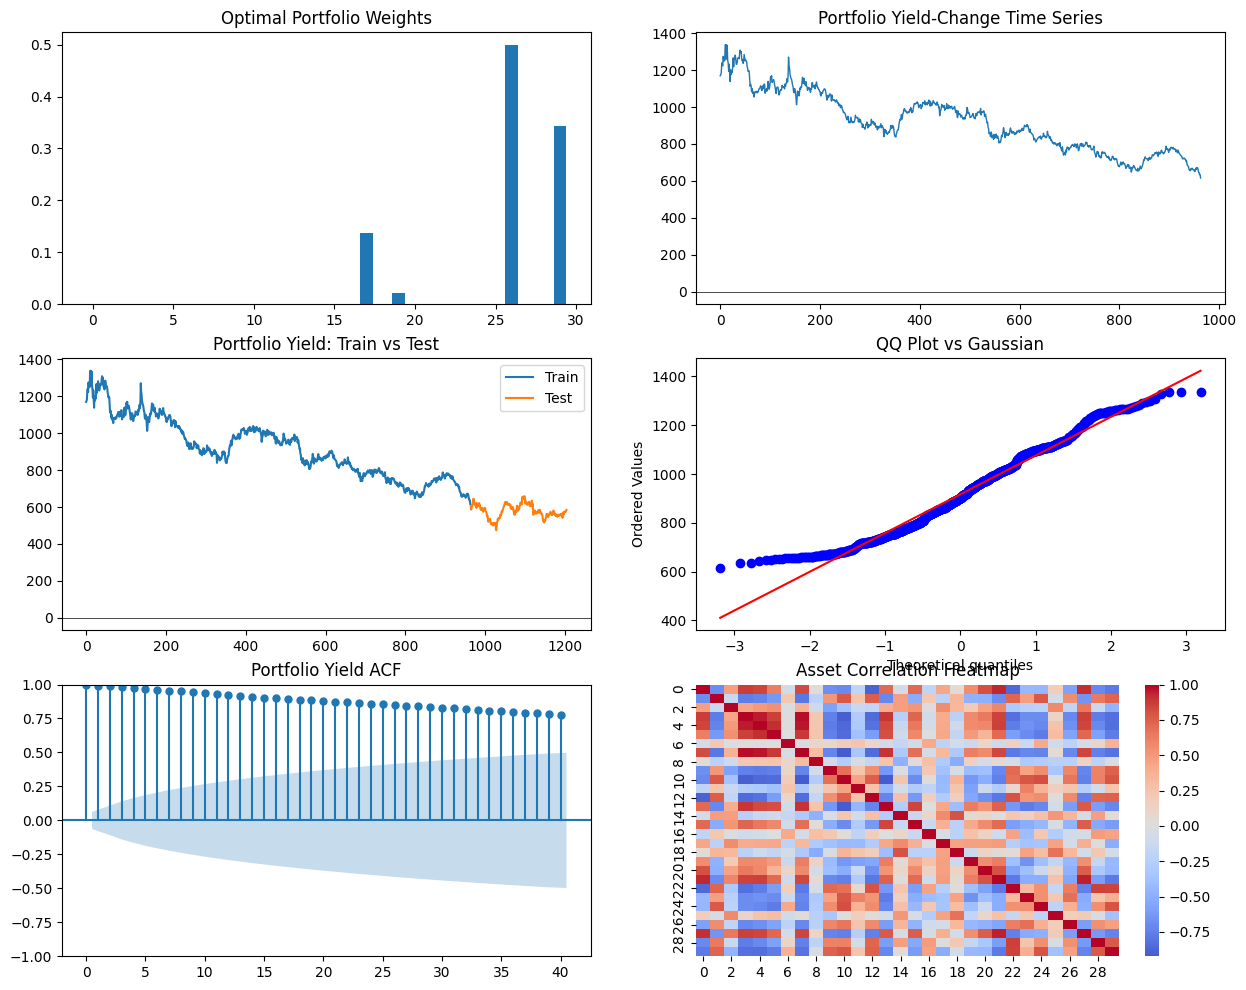

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten() # Flatten to iterate easily
axes[0].bar(range(len(final_w)), final_w)
axes[0].axhline(0, color='black', lw=0.5)
axes[0].set_title("Optimal Portfolio Weights")

x_port = S_train @ final_w
axes[1].plot(x_port, lw=1)
axes[1].axhline(0, color='black', lw=0.5)
axes[1].set_title("Portfolio Yield-Change Time Series")

axes[2].plot(x_port, label="Train")
axes[2].plot(range(len(x_port), len(x_port) + len(S_test)), S_test @ final_w, label="Test")
axes[2].axhline(0, color='black', lw=0.5)
axes[2].legend()
axes[2].set_title("Portfolio Yield: Train vs Test")

sps.probplot(x_port, dist="norm", plot=axes[3])
axes[3].set_title("QQ Plot vs Gaussian")
plot_acf(x_port, ax=axes[4], lags=40)
axes[4].set_title("Portfolio Yield ACF")
corr = pd.DataFrame(S_train).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, ax=axes[5])
axes[5].set_title("Asset Correlation Heatmap")

#Diffusion Models

In [ ]:
T,N = 1,252
dt = T/N

In [ ]:
np.random.seed(42)
def ols_theta(x, dt):
    x = np.asarray(x)
    y = x[1:]
    x_lag = x[:-1]
    X = sm.add_constant(x_lag, has_constant='add')
    res= sm.OLS(y, X).fit()
    if len(res.params) < 2:
        return 1e-4, np.mean(x), np.inf
    alpha, beta = res.params
    a = max((1 - beta) / dt, 1e-6)
    theta = alpha / (a * dt)
    half_life = np.log(2) / a
    return a, theta, half_life

def moments(x):
  mu = np.mean(x)
  sigma = np.std(x)
  return float(mu), float(sigma)

CIR\: $dx_t = -\theta(a - x_t) dt + \sigma\sqrt{x_t} dB_t $

In [ ]:
def vasicek(r_initial, r_history, T, N):
    rng = np.random.default_rng()
    dt = T/N
    Z1 = rng.standard_normal(N)
    dB = sqrt(dt)*Z1
    a, theta, _ = ols_theta(r_history, dt)
    mu = np.mean(r_history)
    sigma = np.std(r_history)
    t = np.linspace(0, T, N+1)
    r = np.zeros(N+1)
    r[0] = r_initial
    dB = np.sqrt(dt) * Z1
    for i in range(1, N+1):
        dr = a * (theta - r[i-1]) * dt + sigma * dB[i-1]
        r[i] = r[i-1] + dr
    return t, r

In [ ]:
def cir(r0, r_history, T, N):
    rng = np.random.default_rng()
    dt = T/N
    Z2 = rng.standard_normal(N)
    dB = sqrt(dt)*Z2
    a, theta, _ = ols_theta(r_history, dt)
    mu, sigma = moments(r_history)
    t = np.linspace(0, T, N+1)
    r = np.zeros(N+1)
    r[0] = r0
    dB = np.sqrt(dt) * Z2
    for i in range(1, N+1):
      dr = a * (theta - r[i-1]) * dt + sigma * np.sqrt(max(r[i-1], 0)) * dB[i-1]
      r[i] = r[i-1] + dr
    return t, r

In [ ]:
def hull_white(r0, r_history, t_mat, T, N):
    t = np.linspace(0, T, N+1)
    rng = np.random.default_rng()
    dt = T/N
    Z3 = rng.standard_normal(N)
    a, _, _ = ols_theta(r_history, dt)
    def theta_t(t_mat, r_history, a, sigma):
      t_unique, indices = np.unique(t_mat, return_index=True)
      r_clean = r_history[indices]
      zr_interp = interp1d(t_unique, r_clean, kind='linear', fill_value="extrapolate")
      z_t = zr_interp(t)
      p_t = np.exp(-z_t * t)
      f_t = -np.gradient(np.log(p_t), dt)
      df_dt = np.gradient(f_t, dt)
      term3 = (sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * t))
      return df_dt + a * f_t + term3
    theta = theta_t(t_mat, r_history, a, sigma)
    r = np.zeros(N+1)
    r[0] = r0
    dB = np.sqrt(dt) * Z3
    for i in range(1, N+1):
      dr = (theta[i-1] - a * r[i-1]) * dt + sigma * dB[i-1]
      r[i] = r[i-1] + dr
    return t, r

BDT model = $d\ln (r)=\left[\theta (t)+\frac{\sigma ^{\prime }(t)}{\sigma (t)}\ln (r)\right]dt+\sigma (t)dW$

In [ ]:
def black_derman_toy(r0, r_history, t_mat, T, N):
    rng = np.random.default_rng()
    dt = T / N
    t = np.linspace(0, T, N + 1)
    ln_history = np.log(r_history)
    sigma0 = np.std(np.diff(ln_history)) / np.sqrt(dt)
    def sigma_bdt(t, s0):
        return s0 * np.ones_like(t)
    sigma_t = sigma_bdt(t, sigma0)
    d_sigma_dt = np.gradient(sigma_t, dt)
    mean_rev_coeff = d_sigma_dt / (sigma_t + 1e-9)
    def _theta_t(maturities, rates, t_steps, s_t):
        t_unique, indices = np.unique(maturities, return_index=True)
        r_clean = np.log(rates[indices])
        zr_interp = interp1d(t_unique, r_clean, kind='linear', fill_value="extrapolate")
        z_t = zr_interp(t_steps)
        p_t = np.exp(-z_t * t_steps)
        f_t = -np.gradient(np.log(p_t + 1e-9), dt)
        df_dt = np.gradient(f_t, dt)
        return df_dt + 0.5 * s_t**2
    theta_t = _theta_t(t_mat, r_history, t, sigma_t)
    ln_r = np.zeros(N + 1)
    ln_r[0] = np.log(r0)
    Z = rng.standard_normal(N)
    for i in range(1, N + 1):
        drift = (theta_t[i-1] + mean_rev_coeff[i-1] * ln_r[i-1]) * dt
        diffusion = sigma_t[i-1] * np.sqrt(dt) * Z[i-1]
        ln_r[i] = ln_r[i-1] + drift + diffusion
    return t, np.exp(ln_r)

In [ ]:
def black_karasinski(r0, r_history, t_mat, T, N):
    rng = np.random.default_rng()
    dt = T / N
    t = np.linspace(0, T, N + 1)
    ln_history = np.log(r_history)
    sigma_t = np.std(np.diff(ln_history)) / np.sqrt(dt)
    a, _, _ = ols_theta(r_history, dt)
    def _theta_t(maturities, rates, t_steps,sigma_t):
      t_unique, indices = np.unique(t_mat, return_index=True)
      zr_interp = interp1d(t_unique, ln_history[indices], kind='linear', fill_value="extrapolate")
      z_t = zr_interp(t)
      p_t = np.exp(-z_t * t)
      f_t = -np.gradient(np.log(p_t + 1e-9), dt)
      df_dt = np.gradient(f_t, dt)
      theta = df_dt + a * f_t + 0.5 * (sigma**2)
      return theta
    theta_t = _theta_t(t_mat, r_history, t, sigma_t)
    ln_r = np.zeros(N + 1)
    ln_r[0] = np.log(r0)
    Z = rng.standard_normal(N)
    for i in range(1, N + 1):
        drift = (theta_t[i-1] - a * ln_r[i-1]) * dt
        diffusion = sigma * np.sqrt(dt) * Z[i-1]
        ln_r[i] = ln_r[i-1] + drift + diffusion
    return t, np.exp(ln_r)

In [ ]:
def price_bond(model_name, r_history, r0, T, t=0, dt=1/252, n_paths=10000):
    tau = T - t
    if tau <= 0: return 1.0
    a, theta_const, _ = ols_theta(r_history, dt)
    sigma = np.std(np.diff(r_history)) / np.sqrt(dt)
    n_steps = int(tau / dt)

    def initial_curve_func(maturity):
        return np.exp(-theta_const * maturity)

    def _price_vasicek():
        B = (1 - np.exp(-a * tau)) / a
        A = np.exp((B - tau) * (a**2 * theta_const - sigma**2 / 2) / (a**2) -
                   (sigma**2 * B**2) / (4 * a))
        return A * np.exp(-B * r0)

    def _price_cir():
        h = np.sqrt(a**2 + 2 * sigma**2)
        exp_h = np.exp(h * tau) - 1
        denom = 2 * h + (a + h) * exp_h
        B = (2 * exp_h) / denom
        A = ((2 * h * np.exp((a + h) * tau / 2)) / denom) ** (2 * a * theta_const / sigma**2)
        return A * np.exp(-B * r0)

    def _price_hull_white():
        B = (1 - np.exp(-a * tau)) / a
        p0_T = initial_curve_func(T)
        eps = 1e-6
        f0_0 = -(np.log(initial_curve_func(eps)) - np.log(initial_curve_func(0.0))) / eps
        ln_A = np.log(p0_T) + B * f0_0 - (sigma**2 / (4 * a)) * (1 - np.exp(-2 * a * t)) * (B**2)
        return np.exp(ln_A) * np.exp(-B * r0)

    def _price_bdt():
        ln_r = np.zeros((n_paths, n_steps + 1))
        ln_r[:, 0] = np.log(r0)
        for i in range(n_steps):
            dw = np.random.normal(0, np.sqrt(dt), n_paths)
            ln_r[:, i+1] = ln_r[:, i] + (np.log(theta_const) - ln_r[:, i]) * dt + sigma * dw
        r_paths = np.exp(ln_r)
        return np.mean(np.exp(-np.trapezoid(r_paths, dx=dt, axis=1)))

    def _price_bk():
        ln_r = np.zeros((n_paths, n_steps + 1))
        ln_r[:, 0] = np.log(r0)
        for i in range(n_steps):
            dw = np.random.normal(0, np.sqrt(dt), n_paths)
            drift = a * (np.log(theta_const) - ln_r[:, i])
            ln_r[:, i+1] = ln_r[:, i] + drift * dt + sigma * dw
        r_paths = np.exp(ln_r)
        return np.mean(np.exp(-np.trapezoid(r_paths, dx=dt, axis=1)))

    models = {
        'Vasicek': _price_vasicek,
        'CIR': _price_cir,
        'HW': _price_hull_white,
        'BDT': _price_bdt,
        'BK': _price_bk
    }

    results = {m: models[m]() for m in models if m in models}
    return pd.Series(results)


Code each expected values and variance

#Indonesian Government Bonds

Data is from Bloomberg

In [4]:
BASE = Path("/content/drive/MyDrive/BloombergData")
CSV_PATH = BASE / "indo_bonds.csv"   # change if needed
df = pd.read_csv(CSV_PATH)
df

,ID,DATE,CURRENCY,PX_LAST
0,GTIDR8Y Govt,2021-01-25,NaN,6.336662
1,GTIDR8Y Govt,2021-01-26,NaN,6.330781
2,GTIDR8Y Govt,2021-01-27,NaN,6.321076
3,GTIDR8Y Govt,2021-01-28,NaN,6.304178
4,GTIDR8Y Govt,2021-01-29,NaN,6.260007
...,...,...,...,...
36537,CTIDR10Y Govt,2026-01-21,NaN,101.359000
36538,CTIDR10Y Govt,2026-01-22,NaN,101.309000
36539,CTIDR10Y Govt,2026-01-23,NaN,100.874000
36540,CTIDR10Y Govt,2026-01-24,NaN,100.874000


In [5]:
series = pd.DataFrame({
"Price": df["PX_LAST"],
"DATE": pd.to_datetime(df["DATE"]),
"ID": df["ID"],
}).dropna()
series = series.sort_values("DATE").reset_index(drop=True)
series

,Price,DATE,ID
0,6.336662,2021-01-25,GTIDR8Y Govt
1,5.920991,2021-01-25,GTIDR6Y Govt
2,6.237597,2021-01-25,GTIDR15Y Govt
3,6.841422,2021-01-25,GTIDR20Y Govt
4,6.182061,2021-01-25,GTIDR7Y Govt
...,...,...,...
21068,101.187000,2026-01-25,CTIDR6Y Govt
21069,4.902996,2026-01-25,GTUSDID9Y Govt
21070,95.383130,2026-01-25,CTUSDID30Y Govt
21071,105.466000,2026-01-25,CTIDR15Y Govt


annualized maturities

In [6]:
t_mat_map = {
"CTIDR10Y": 10,
"CTIDR15Y": 15,
"CTIDR20Y": 20,
"CTIDR5Y": 5,
"CTIDR6Y": 6,
"CTIDR7Y": 7,
"CTIDR8Y": 8,
"CTUSDID30Y": 30,
"CTUSDID9Y": 9,
"GTIDR10Y": 10,
"GTIDR15Y": 15,
"GTIDR20Y": 20,
"GTIDR5Y": 5,
"GTIDR6Y": 6,
"GTIDR7Y": 7,
"GTIDR8Y": 8,
"GTUSDID30Y": 30,
"GTUSDID9Y": 9,
"INDOGB_2036": 10.2,
"INDOGB": 10,
"INDON_2031": 5.1,
"INDON": 10,
}

In [14]:
series['ID_clean'] = series['ID'].str.replace(r'\s+Govt$', '', regex=True)
series['Maturity'] = series['ID_clean'].map(t_mat_map).astype(float)
y_df = series.loc[series['Maturity'] > 0].copy()
is_price = y_df['ID_clean'].str.startswith(('GT', 'INDOGB'))
y_df['Yield'] = np.nan
y_df.loc[~is_price, 'Yield'] = y_df.loc[~is_price, 'Price']
y_df.loc[is_price, 'Yield'] = (
    -np.log(y_df.loc[is_price, 'Price'] / 100.0)
    / y_df.loc[is_price, 'Maturity']
)
y_df['Yield'] = y_df['Yield'].clip(lower=1e-6)
y_df

,Price,DATE,ID,ID_clean,Maturity,Yield
0,6.336662,2021-01-25,GTIDR8Y Govt,GTIDR8Y,8.0,0.344852
1,5.920991,2021-01-25,GTIDR6Y Govt,GTIDR6Y,6.0,0.471111
2,6.237597,2021-01-25,GTIDR15Y Govt,GTIDR15Y,15.0,0.184972
3,6.841422,2021-01-25,GTIDR20Y Govt,GTIDR20Y,20.0,0.134109
4,6.182061,2021-01-25,GTIDR7Y Govt,GTIDR7Y,7.0,0.397645
...,...,...,...,...,...,...
21068,101.187000,2026-01-25,CTIDR6Y Govt,CTIDR6Y,6.0,101.187000
21069,4.902996,2026-01-25,GTUSDID9Y Govt,GTUSDID9Y,9.0,0.335036
21070,95.383130,2026-01-25,CTUSDID30Y Govt,CTUSDID30Y,30.0,95.383130
21071,105.466000,2026-01-25,CTIDR15Y Govt,CTIDR15Y,15.0,105.466000


In [15]:
y_dfs = {}
for ID, sub in y_df.groupby('ID_clean'):
    sub = sub.sort_values('DATE')
    y = sub['Yield'].values
    if len(y) < 2:
        continue
    y_dfs[ID] = y

In [23]:
all_dy_time: dict[str, np.ndarray]
all_dy_time = y_dfs

In [25]:
df_dy = pd.DataFrame({k: pd.Series(v) for k, v in all_dy_time.items()})
df_dy.head()

,CTIDR10Y,CTIDR15Y,CTIDR20Y,CTIDR5Y,CTIDR6Y,CTIDR7Y,CTIDR8Y,CTUSDID30Y,CTUSDID9Y,GTIDR10Y,GTIDR15Y,GTIDR20Y,GTIDR5Y,GTIDR6Y,GTIDR7Y,GTIDR8Y,GTUSDID30Y,GTUSDID9Y
0,99.798,99.084,98.809,100.102,99.236,100.5555,99.0410,92.62658,101.7395,0.277250,0.184972,0.134109,0.590322,0.471111,0.397645,0.344852,0.115593,0.359489
1,99.727,99.191,98.940,100.239,99.871,100.4110,98.1235,92.36883,101.7395,0.277539,0.184876,0.134107,0.591394,0.471911,0.397645,0.344968,0.115808,0.359151
2,99.727,99.191,98.940,100.134,100.161,100.3610,99.1890,91.89950,101.7395,0.277968,0.184780,0.134203,0.591089,0.472744,0.397645,0.345160,0.115816,0.359151
3,99.727,99.191,98.940,100.134,100.119,100.4360,99.2640,92.46222,101.7395,0.277870,0.184770,0.134152,0.592322,0.474597,0.397645,0.345495,0.115646,0.359151
4,99.993,98.197,97.975,100.134,100.119,100.4360,99.2640,92.46222,101.7395,0.278313,0.184876,0.134226,0.593617,0.476476,0.397645,0.346374,0.115501,0.356275


(1257, 18)
      CTIDR10Y  CTIDR15Y  CTIDR20Y  CTIDR5Y  CTIDR6Y   CTIDR7Y  CTIDR8Y  \
0       99.798    99.084    98.809  100.102   99.236  100.5555  99.0410   
1       99.727    99.191    98.940  100.239   99.871  100.4110  98.1235   
2       99.727    99.191    98.940  100.134  100.161  100.3610  99.1890   
3       99.727    99.191    98.940  100.134  100.119  100.4360  99.2640   
4       99.993    98.197    97.975  100.134  100.119  100.4360  99.2640   
...        ...       ...       ...      ...      ...       ...      ...   
1252       NaN       NaN       NaN      NaN   96.397       NaN      NaN   
1253       NaN       NaN       NaN      NaN   96.259       NaN      NaN   
1254       NaN       NaN       NaN      NaN   96.213       NaN      NaN   
1255       NaN       NaN       NaN      NaN   96.109       NaN      NaN   
1256       NaN       NaN       NaN      NaN   96.068       NaN      NaN   

      CTUSDID30Y  CTUSDID9Y  GTIDR10Y  GTIDR15Y  GTIDR20Y   GTIDR5Y   GTIDR6Y  \
0      

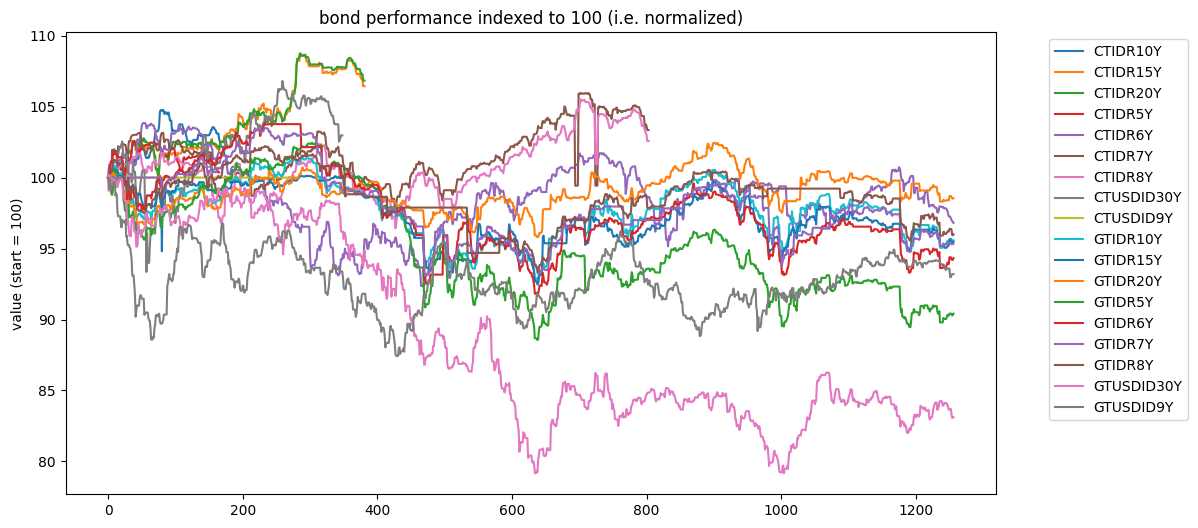

In [29]:
min_assets = int(0.6 * df_dy.shape[1])
df_dy_clean = df_dy.dropna(thresh=min_assets)
index_bonds = df_dy_clean.columns
print(df_dy_clean.shape)
print(df_dy_clean)
df_dy_clean.isna().mean().sort_values().head().dropna()
print(index_bonds)
df_indexed = (df_dy_clean / df_dy_clean.iloc[0]) * 100
df_indexed.plot(figsize=(12, 6))
plt.title("bond performance indexed to 100 (i.e. normalized)")
plt.ylabel("value (start = 100)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
Z = df_dy_clean.values
print(Z)

[[-7.10000000e-02  1.07000000e-01  1.31000000e-01 ...  1.39278316e-03
   2.58062215e-03 -4.05201076e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.30124366e-03
   9.92850097e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.01528795e-03
  -2.04552838e-03  0.00000000e+00]
 ...
 [            nan             nan             nan ... -1.60946798e-02
  -3.68287742e-03  3.12611944e-03]
 [            nan             nan             nan ... -6.93059972e-04
   7.04721490e-04  0.00000000e+00]
 [            nan             nan             nan ...  2.18187155e-03
   0.00000000e+00  0.00000000e+00]]


Including the Tickers

##Gradient Descent Simulation

In [ ]:
Z = df_dy_clean.values
Z_train = Z[:split_idx]
Z_test  = Z[split_idx:]

In [ ]:
stds = Z_train.std(axis=0)
bad_cols = np.where(stds == 0)[0]
print("Zero-variance columns:", bad_cols)
nan_cols = np.where(np.isnan(Z_train).any(axis=0))[0]
print("NaN columns:", nan_cols)

Zero-variance columns: []
NaN columns: [0 1 2 3 5 6 7 8]


In [ ]:
valid_cols = np.where(
    (Z_train.std(axis=0) > 0) &
    (~np.isnan(Z_train).any(axis=0))
)[0]

Z_train = Z_train[:, valid_cols]
Z_test  = Z_test[:, valid_cols]

In [ ]:
w_initial = np.ones(Z_train.shape[1]) / Z_train.shape[1]
final_w = run_projected_gradient_descent(
    Z_train,
    w_initial,
    pgd_settings
)
print("final_w shape:", final_w.shape)
print("sum weights:", final_w.sum())

final_w shape: (10,)
sum weights: 0.9999999999989998


In [ ]:
print(pd.DataFrame([w_initial, index_bonds]))

         0         1         2        3        4        5        6   \
0       0.1       0.1       0.1      0.1      0.1      0.1      0.1   
1  CTIDR10Y  CTIDR15Y  CTIDR20Y  CTIDR5Y  CTIDR6Y  CTIDR7Y  CTIDR8Y   

           7          8         9         10        11       12       13  \
0         0.1        0.1       0.1      None      None     None     None   
1  CTUSDID30Y  CTUSDID9Y  GTIDR10Y  GTIDR15Y  GTIDR20Y  GTIDR5Y  GTIDR6Y   

        14       15          16         17  
0     None     None        None       None  
1  GTIDR7Y  GTIDR8Y  GTUSDID30Y  GTUSDID9Y  


In [ ]:
print("Weights sum:", final_w.sum())
print("Min / Max weight:", final_w.min(), final_w.max())
print(pd.DataFrame([final_w, index_bonds]))

Weights sum: 0.9999999999989998
Min / Max weight: 0.0 0.5686663244706004
         0         1         2         3        4        5        6   \
0       0.0       0.0  0.113086  0.568666      0.0      0.0      0.0   
1  CTIDR10Y  CTIDR15Y  CTIDR20Y   CTIDR5Y  CTIDR6Y  CTIDR7Y  CTIDR8Y   

           7          8         9         10        11       12       13  \
0         0.0   0.317245  0.001002      None      None     None     None   
1  CTUSDID30Y  CTUSDID9Y  GTIDR10Y  GTIDR15Y  GTIDR20Y  GTIDR5Y  GTIDR6Y   

        14       15          16         17  
0     None     None        None       None  
1  GTIDR7Y  GTIDR8Y  GTUSDID30Y  GTUSDID9Y  


In [ ]:
engines = {
    "OU": engine_ou,
    "Vasicek": engine_vasicek,
    "CIR": engine_cir,
    "HW": engine_hw,
    "BDT": engine_bdt,
    "BK": engine_bk
}

In [ ]:
params_map = {
    "OU": {'mu': 0.38, 'sigma_sq': 5100, 'theta': -4.0},
    "Vasicek": {'a': 0.8, 'b': 0.1, 'sigma': 0.07},
    "CIR": {'a': 0.8, 'b': 0.02, 'sigma': 0.17},
    "HW": {'a': 0.8, 'theta': 0.5, 'sigma': 0.07},
    "BDT": {'theta': 0.5, 'sigma': 70.0},
    "BK": {'a': 1.0, 'theta': 0.7, 'sigma': 90.0}
}

In [ ]:
print(
    f"{'Model':>10} {'Iter':>5} "
    f"{'Params':>40} "
    f"{'Train_NLL':>12} {'Test_NLL':>12}"
)
print("-"*95)

for name, engine in engines.items():
    param_list = param_sweeps[name]   # list of dicts
    for i, params in enumerate(param_list):
        train_nll = portfolio_nll(
            final_w,
            Z_train,
            1/252,
            engine,
            params
        )
        test_nll = portfolio_nll(
            final_w,
            Z_test,
            1/252,
            engine,
            params
        )
        param_str = ", ".join(
            f"{k}:{v:.3g}" if isinstance(v, float) else f"{k}:{v}"
            for k, v in params.items()
        )
        print(
            f"{name:>10} {i:>5} "
            f"{param_str:>40} "
            f"{train_nll/1000:>12.6f} "
            f"{test_nll/1000:>12.6f}"
        )

     Model  Iter                                   Params    Train_NLL     Test_NLL
-----------------------------------------------------------------------------------------------
        OU     0 mu:0.384, sigma_sq:5.09e+03, theta:-3.81     0.923198     0.232156
        OU     1  mu:0.394, sigma_sq:5.04e+03, theta:6.19     0.923196     0.232152
        OU     2     mu:0.404, sigma_sq:5e+03, theta:16.2     0.923206     0.232151
        OU     3  mu:0.414, sigma_sq:4.96e+03, theta:26.2     0.923232     0.232154
        OU     4  mu:0.424, sigma_sq:4.92e+03, theta:36.2     0.923276     0.232162
        OU     5  mu:0.434, sigma_sq:4.87e+03, theta:46.2     0.923340     0.232175
        OU     6  mu:0.444, sigma_sq:4.83e+03, theta:56.2     0.923428     0.232194
        OU     7  mu:0.454, sigma_sq:4.79e+03, theta:66.2     0.923543     0.232219
        OU     8  mu:0.464, sigma_sq:4.74e+03, theta:76.2     0.923687     0.232252
        OU     9   mu:0.474, sigma_sq:4.7e+03, theta:86.2     0.

/tmp/ipython-input-3497425653.py:3: RuntimeWarning: divide by zero encountered in log
  m_ln = np.log(x_t) + theta * dt
/tmp/ipython-input-3497425653.py:3: RuntimeWarning: invalid value encountered in log
  m_ln = np.log(x_t) + theta * dt
/tmp/ipython-input-2237203081.py:4: RuntimeWarning: divide by zero encountered in log
  m_ln = np.log(x_t) * phi + (theta / a) * (1 - phi)
/tmp/ipython-input-2237203081.py:4: RuntimeWarning: invalid value encountered in log
  m_ln = np.log(x_t) * phi + (theta / a) * (1 - phi)


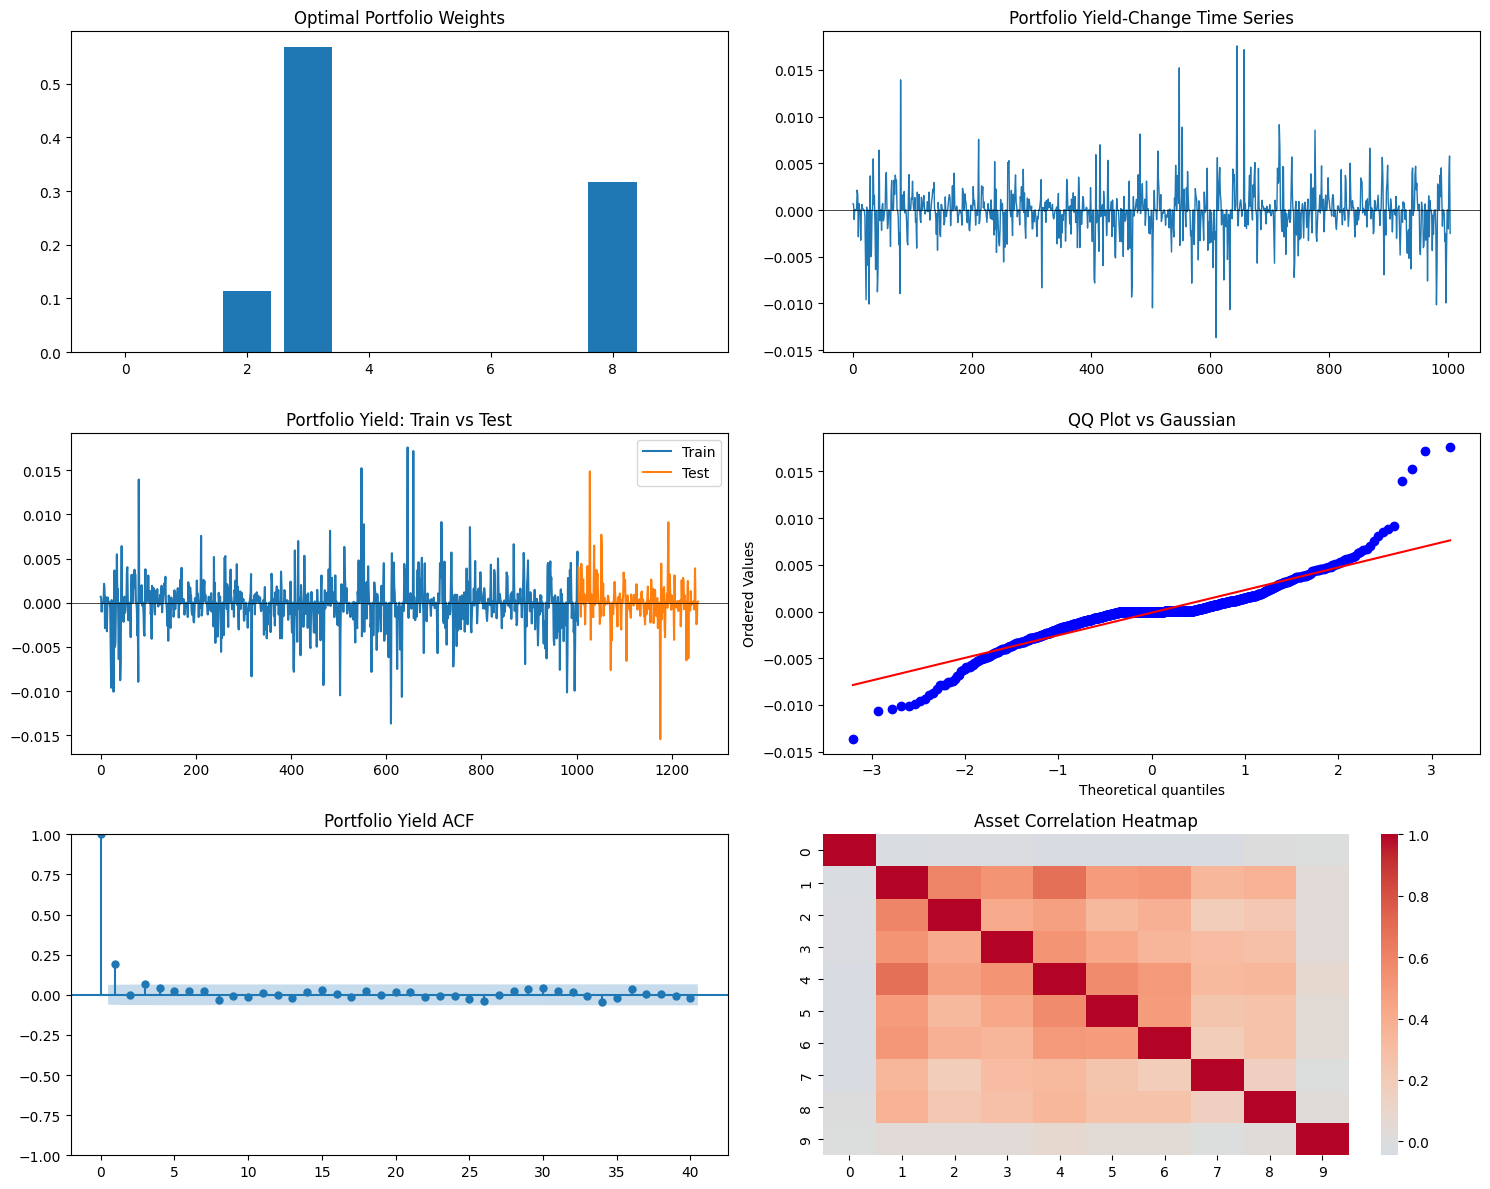

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten() # Flatten to iterate easily
axes[0].bar(range(len(final_w)), final_w)
axes[0].axhline(0, color='black', lw=0.5)
axes[0].set_title("Optimal Portfolio Weights")

x_port = Z_train @ final_w
axes[1].plot(x_port, lw=1)
axes[1].axhline(0, color='black', lw=0.5)
axes[1].set_title("Portfolio Yield-Change Time Series")

axes[2].plot(x_port, label="Train")
axes[2].plot(range(len(x_port), len(x_port) + len(Z_test)), Z_test @ final_w, label="Test")
axes[2].axhline(0, color='black', lw=0.5)
axes[2].legend()
axes[2].set_title("Portfolio Yield: Train vs Test")

sps.probplot(x_port, dist="norm", plot=axes[3])
axes[3].set_title("QQ Plot vs Gaussian")
plot_acf(x_port, ax=axes[4], lags=40)
axes[4].set_title("Portfolio Yield ACF")
corr = pd.DataFrame(Z_train).corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, ax=axes[5])
axes[5].set_title("Asset Correlation Heatmap")

plt.tight_layout()
plt.show()

#USD Overnight Index Swap Simulation and Bond Prices


In [ ]:
BASE = Path("/content/drive/MyDrive/BloombergData")
CSV_PATH = BASE / "usd_ois_curve_long.csv"   # change if needed
df = pd.read_csv(CSV_PATH)
df

,Unnamed: 0,TICKER,DATE,CURRENCY,ZeroRate,Maturity
0,0,USSO1Z Curncy,2021-01-25,NaN,0.07925,0.083333
1,1,USSO1Z Curncy,2021-01-26,NaN,0.07520,0.083333
2,2,USSO1Z Curncy,2021-01-27,NaN,0.07500,0.083333
3,3,USSO1Z Curncy,2021-01-28,NaN,0.07510,0.083333
4,4,USSO1Z Curncy,2021-01-29,NaN,0.06100,0.083333
...,...,...,...,...,...,...
3655,3655,USSO1Y Curncy,NaN,NaN,NaN,1.000000
3656,3656,USSO2Y Curncy,NaN,NaN,NaN,2.000000
3657,3657,USSO5Y Curncy,NaN,NaN,NaN,5.000000
3658,3658,USSO10Y Curncy,NaN,NaN,NaN,10.000000


Direct Test to model by assuming same Zero Rates

In [ ]:
zr = df['ZeroRate']
maturity = df['Maturity']
time = df['DATE']
series = pd.DataFrame({'Zero Rate': zr, 'Maturity': maturity, 'DATE': time})
series = series.dropna()
series

,Zero Rate,Maturity,DATE
0,0.07925,0.083333,2021-01-25
1,0.07520,0.083333,2021-01-26
2,0.07500,0.083333,2021-01-27
3,0.07510,0.083333,2021-01-28
4,0.06100,0.083333,2021-01-29
...,...,...,...
3649,3.63400,0.250000,2026-01-21
3650,3.63400,0.250000,2026-01-22
3651,3.63504,0.250000,2026-01-23
3652,3.63504,0.250000,2026-01-24


In [ ]:
series['DATE'] = pd.to_datetime(series['DATE'])
series = series.sort_values('DATE').reset_index(drop=True)
series['Zero Rate'] = pd.to_numeric(series['Zero Rate'], errors='coerce')
series = series.dropna(subset=['Zero Rate'])


zr_df = series['Zero Rate']
time = series['DATE']
t_mat = series['Maturity']

mu, sigma = moments(zr_df)
r0 = float(zr_df.iloc[0])
a, theta, half_life = ols_theta(zr_df, dt)

In [ ]:
print(len(zr_df))
print(len(t_mat))

3654
3654


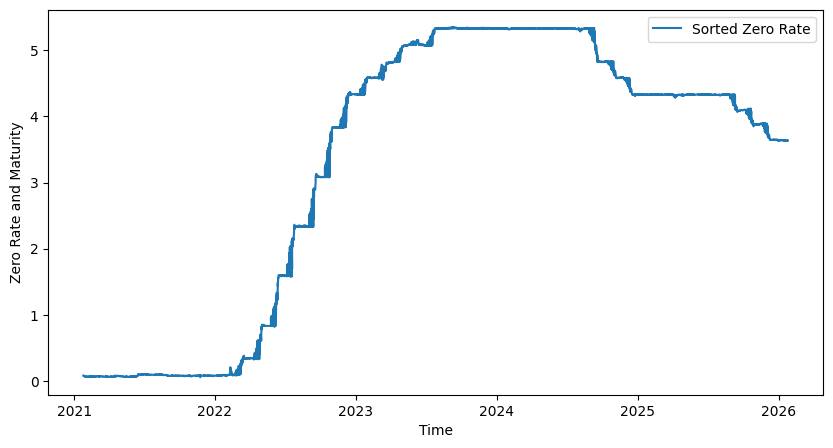

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(time, zr_df, label='Sorted Zero Rate')
plt.xlabel('Time')
plt.ylabel('Zero Rate and Maturity')
plt.legend()
plt.show()

In [ ]:
N, T = 252, 1
dt = T/N
t, vasicek_sim = vasicek(r0, zr_df, T, N)
t, cir_sim = cir(r0, zr_df, T, N)
t, hw_sim = hull_white(r0, zr_df, t_mat, T, N)
t, bdt_sim = black_derman_toy(r0, zr_df,t_mat, T, N)
t, bk_sim = black_karasinski(r0, zr_df ,t_mat, T, N)

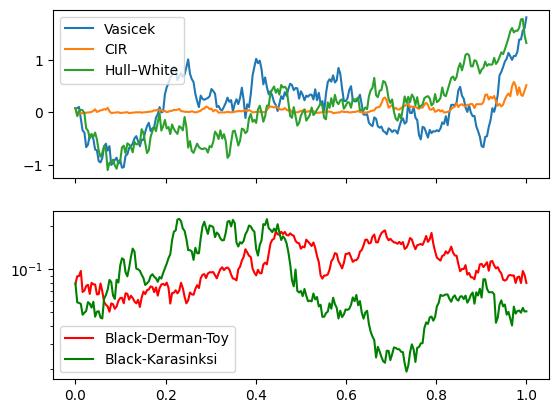

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True)

ax[0].plot(t, vasicek_sim, label="Vasicek")
ax[0].plot(t, cir_sim, label="CIR")
ax[0].plot(t, hw_sim, label="Hull–White")
ax[0].legend()

ax[1].plot(t, bdt_sim, label="Black-Derman-Toy", color="red")
ax[1].plot(t, bk_sim, label="Black-Karasinksi", color="green")
ax[1].set_yscale("log")
ax[1].legend()

Including the Tickers

In [ ]:
tickers = [
    "USSO1OY Curncy",
    "USSO1Y Curncy",
    "USSO1Z Curncy",
    "USSO30Y Curncy",
    "USSO3Z Curncy",
    "USSO5Y Curncy",
    "USSO6Z Curncy",
]

# build per ticker
zr = {}
for tkr in tickers:
    sub = (
        df[df['TICKER'] == tkr]
          .sort_values('DATE')
          .set_index('DATE')['ZeroRate']
    )
    zr[tkr] = sub.dropna()

# --- show lengths (sanity check) ---
print("by ticker lengths (no intersection):")
for k, v in zr.items():
    print(k, len(v))

by ticker lengths (no intersection):
USSO1OY Curncy 0
USSO1Y Curncy 0
USSO1Z Curncy 1827
USSO30Y Curncy 0
USSO3Z Curncy 1827
USSO5Y Curncy 0
USSO6Z Curncy 0


In [ ]:
zr_dfs = {}
mapping = {
    "USSO1OY": "USSO1OY Curncy",
    "USSO1Y":  "USSO1Y Curncy",
    "USSO1Z":  "USSO1Z Curncy",
    "USSO3Z":  "USSO3Z Curncy",
    "USSO5Y":  "USSO5Y Curncy",
    "USSO6Z":  "USSO6Z Curncy",
    "USSO30Y": "USSO30Y Curncy",
}

In [ ]:
for short, full in mapping.items():
    if full in zr and len(zr[full]) > 0:
        zr_dfs[short] = zr[full]
    else:
        print(f"warning: ticker missing or empty -> {full}")
try:
    N
    T
except NameError:
    N, T = 1000, 1
dt = T / N

In [ ]:
vasicek_sims = {}
cir_sims     = {}
hw_sims      = {}
bdt_sims     = {}
bk_sims      = {}

for j, (ticker, zr_df) in enumerate(zr_dfs.items()):
    if zr_df is None or len(zr_df) == 0:
        print(f"skipping {ticker} (empty series)")
        continue
    print(f"simulating {ticker} (j={j}), n_obs={len(zr_df)}")
    r0 = float(zr_df.iloc[0])
    t, vasicek_sims[ticker] = vasicek(r0, zr_df, T, N)
    t, cir_sims[ticker]     = cir(r0, zr_df, T, N)
    t, hw_sims[ticker]      = hull_white(r0, zr_df, t_mat, T, N)
    t, bdt_sims[ticker]     = black_derman_toy(r0, zr_df, t_mat, T, N)
    t, bk_sims[ticker]      = black_karasinski(r0, zr_df, t_mat, T, N)

Simulating USSO1Z (j=0), n_obs=1827
Simulating USSO3Z (j=1), n_obs=1827


/tmp/ipython-input-2172457169.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_clean = r_history[indices]
/tmp/ipython-input-2914882734.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_clean = np.log(rates[indices])
/tmp/ipython-input-1636791664.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zr_interp = interp1d(t_unique, ln_history[indices], kind='linear', fill_value="extrapolate")


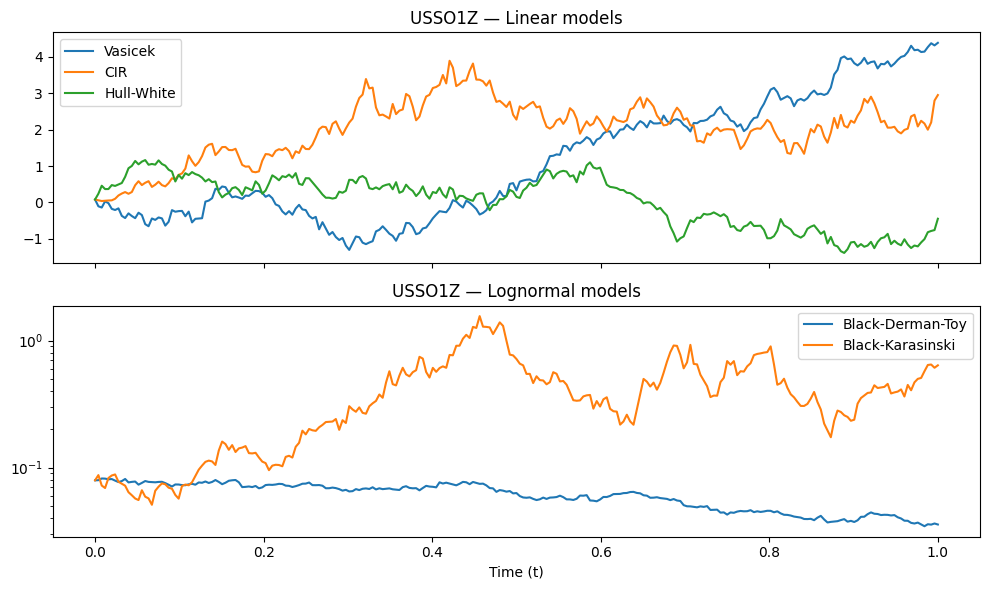

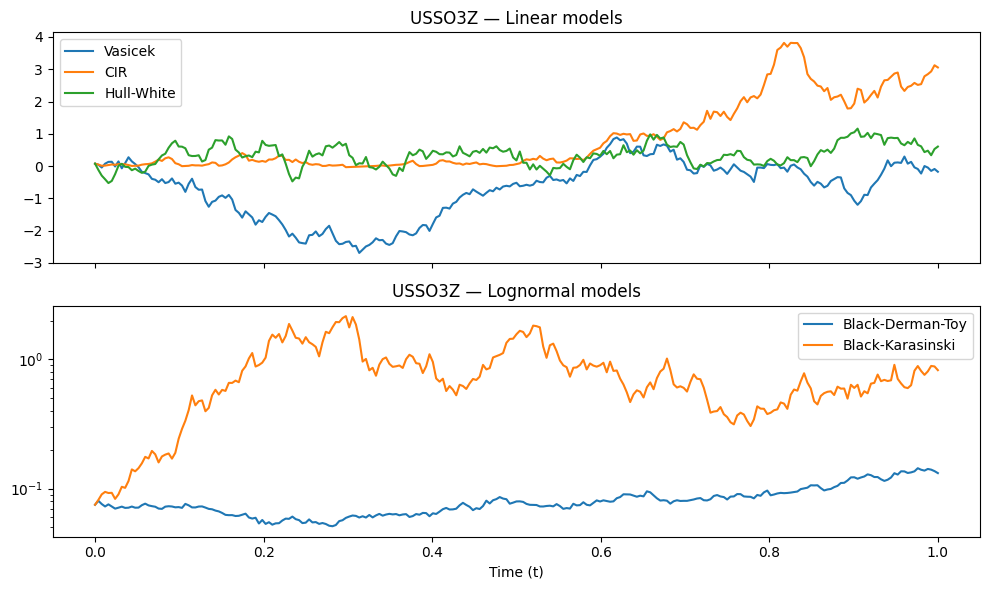

In [ ]:
for ticker in ["USSO1Z", "USSO3Z"]:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ax1.plot(t, vasicek_sims[ticker], label="Vasicek")
    ax1.plot(t, cir_sims[ticker],     label="CIR")
    ax1.plot(t, hw_sims[ticker],      label="Hull-White")
    ax1.set_title(f"{ticker} — Linear models")
    ax1.legend()
    ax2.plot(t, bdt_sims[ticker], label="Black-Derman-Toy")
    ax2.plot(t, bk_sims[ticker],  label="Black-Karasinski")
    ax2.set_yscale("log")
    ax2.set_title(f"{ticker} — Lognormal models")
    ax2.legend()
    ax2.set_xlabel("Time (t)")
    plt.tight_layout()
    plt.show()

In [ ]:
target_models = ['Vasicek', 'CIR', 'HW', 'BDT', 'BK']
all_ticker_prices = {}
for ticker, zr_df in zr_dfs.items():
  if zr_df is None or len(zr_df) == 0: continue
  r0 = float(zr_df.iloc[-1])
  z_mkt = r0
  p_mkt = np.exp(-z_mkt * T)
  raw_prices = price_bond(target_models, zr_df, r0, T=1, t=0)
  norm_prices = p_mkt * (raw_prices / raw_prices.iloc[0])
  all_ticker_prices[ticker] = norm_prices
df_final_prices = pd.DataFrame(all_ticker_prices).T
df_final_yields = -np.log(df_final_prices)/1.0
print("asset yields per Ticker and Model:")
print(df_final_yields)

asset yields per Ticker and Model:
        Vasicek       CIR        HW       BDT        BK
USSO1Z  3.63355  3.581152  3.653321  4.073845  3.459824
USSO3Z  3.63504  3.604538  3.646377  4.144286  3.508876


In [ ]:
all_prices_time = {}
all_prices_norm = {}
all_yields_time = {}
all_dy_time     = {}
for ticker, zr_df in zr_dfs.items():
    if zr_df is None or len(zr_df) < 2:
        continue
    P_raw = np.exp(-zr_df.values * T)
    P_norm = P_raw / P_raw[0]
    Y = -np.log(P_norm) / T
    dY = np.diff(Y)
    all_prices_time[ticker] = P_raw          # shape (T_obs,)
    all_prices_norm[ticker] = P_norm         # shape (T_obs,)
    all_yields_time[ticker] = Y              # shape (T_obs,)
    all_dy_time[ticker]     = dY             # shape (T_obs-1,)
print(pd.DataFrame(all_dy_time))

       USSO1Z   USSO3Z
0    -0.00405  0.00275
1    -0.00020 -0.00475
2     0.00010  0.00000
3    -0.01410 -0.01100
4     0.00000  0.00000
...       ...      ...
1821 -0.00200  0.00000
1822 -0.00300  0.00000
1823  0.00055  0.00104
1824  0.00000  0.00000
1825  0.00000  0.00000

[1826 rows x 2 columns]


##Gradient Descent Simulation

In [ ]:
engines = {
    "OU": engine_ou,
    "Vasicek": engine_vasicek,
    "CIR": engine_cir,
    "HW": engine_hw,
    "BDT": engine_bdt,
    "BK": engine_bk
}

In [ ]:
z = all_dy_time[ticker].reshape(-1, 1)
z_all = z[~np.isnan(z).any(axis=1) & (z > 0).all(axis=1)]
split_idx = int(len(z_all) * 0.8)
z_train = z_all[:split_idx]
z_test = z_all[split_idx:]
split_idx = int(len(z_all) * 0.8)

In [ ]:
z_train = z_all[:split_idx]
z_test = z_all[split_idx:]
pgd_settings = {
    'max_iter': 500,
    'stepsize': 0.001,
    'gamma': 0.0,
    'eta': 4
}

In [ ]:
print(pd.DataFrame(z_train))
print(pd.DataFrame(z_test))

           0
0    0.00275
1    0.00100
2    0.00800
3    0.00700
4    0.00400
..       ...
425  0.00060
426  0.00200
427  0.00030
428  0.00010
429  0.00090

[430 rows x 1 columns]
           0
0    0.00200
1    0.00100
2    0.00270
3    0.00130
4    0.00100
..       ...
103  0.00199
104  0.00500
105  0.00501
106  0.00076
107  0.00104

[108 rows x 1 columns]


In [ ]:
w_initial = np.ones(z_train.shape[1])/z_train.shape[1]
final_w = run_projected_gradient_descent(z_train, w_initial, pgd_settings)

In [ ]:
print(w_initial)
print(final_w)

[1.]
[1.]


In [ ]:
param_sweeps = {
    "OU": [
        {'mu': 0.374212 + 0.01*i,'sigma_sq': 5130.514053 - 43.0*i,'theta': -13.806547 + 10.0*i}
        for i in range(1, 15)],
    "Vasicek": [
        {'a': 0.2 + 0.1*i,'b': 0.1,'sigma': 0.01 + 0.01*i}
        for i in range(1, 10)],
    "CIR": [
        {'a': 0.2 + 0.1*i,'b': 0.02,'sigma': 0.05 + 0.02*i}
        for i in range(1, 10)],
    "HW": [
        {'a': 0.2 + 0.1*i,'theta': 0.3 + 0.1*i,'sigma': 0.01 + 0.01*i
        }
        for i in range(1, 4)],
    "BDT": [
        {'theta': 0.3 + 0.1*i,'sigma': 50.0 + 10.0*i}
        for i in range(1, 10)],
    "BK": [
        # Use parameters scaled similarly to your working OU parameters
        {'a': 0.5 + 0.1*i, 'theta': 0.3 + 0.1*i,'sigma': 50.0 + 10.0*i}
        for i in range(1, 10)]
}

In [ ]:
results = []
print(f"{'Model':<10} {'Iter':>4} {'Params (Keys: Values)':<45} {'Train_NLL':>12} {'Test_NLL':>12}")
print("-" * 90)
for model_name, engine in engines.items():
    for i, params in enumerate(param_sweeps[model_name]):

        train_nll = portfolio_nll(final_w, z_train, 1/252, engine, params)
        test_nll = portfolio_nll(final_w, z_test,  1/252, engine, params)
        param_str = ", ".join([f"{k}:{v:.3f}" for k, v in params.items()])

        print(
            f"{model_name:<10} "
            f"{i:>4} "
            f"{param_str:<45} "
            f"{train_nll/1000:>12.6f} "
            f"{test_nll/1000:>12.6f}"
        )
        res_entry = {
            'model': model_name,
            'iter': i,
            'train_nll': train_nll,
            'test_nll': test_nll
        }
        res_entry.update(params)
        results.append(res_entry)

print("\nsukses.")
df_results = pd.DataFrame(results)
cols = ['model', 'iter'] + [c for c in df_results.columns if c not in ['model', 'iter', 'train_nll', 'test_nll']] + ['train_nll', 'test_nll']
df_results = df_results[cols]
df_results.sort_values(['model', 'test_nll'], inplace=True)
print(df_results.head(20))

Model      Iter Params (Keys: Values)                            Train_NLL     Test_NLL
------------------------------------------------------------------------------------------
OU            0 mu:0.384, sigma_sq:5087.514, theta:-3.807         0.395739     0.099828
OU            1 mu:0.394, sigma_sq:5044.514, theta:6.193          0.395736     0.099824
OU            2 mu:0.404, sigma_sq:5001.514, theta:16.193         0.395738     0.099822
OU            3 mu:0.414, sigma_sq:4958.514, theta:26.193         0.395747     0.099820
OU            4 mu:0.424, sigma_sq:4915.514, theta:36.193         0.395763     0.099821
OU            5 mu:0.434, sigma_sq:4872.514, theta:46.193         0.395788     0.099824
OU            6 mu:0.444, sigma_sq:4829.514, theta:56.193         0.395823     0.099830
OU            7 mu:0.454, sigma_sq:4786.514, theta:66.193         0.395870     0.099838
OU            8 mu:0.464, sigma_sq:4743.514, theta:76.193         0.395929     0.099849
OU            9 mu:0.474, sig

In [ ]:
print(f"{'Iter':>5} {'a':>8} {'sigma':>10} {'Train_NLL':>12} {'Test_NLL':>12}")

for i in range(1, 10):
    params = {
        'a': 0.2 + 0.1*i,
        'b': 0.0,
        'sigma': 0.01 + 0.01*i
    }

    train_nll = portfolio_nll(final_w, z_train, 1/252, engine_vasicek, params)
    test_nll  = portfolio_nll(final_w, z_test,  1/252, engine_vasicek, params)

    print(
        f"{i:>5} "
        f"{params['a']:>8.3f} "
        f"{params['sigma']:>10.4f} "
        f"{train_nll/1000:>12.6f} "
        f"{test_nll/1000:>12.6f}"
    )

 Iter        a      sigma    Train_NLL     Test_NLL
    1    0.300     0.0200   160.562512     0.945104
    2    0.400     0.0300    71.576884     0.471368
    3    0.500     0.0400    40.432056     0.305706
    4    0.600     0.0500    26.016538     0.229118
    5    0.700     0.0600    18.185947     0.187576
    6    0.800     0.0700    13.464391     0.162571
    7    0.900     0.0800    10.399952     0.146376
    8    1.000     0.0900     8.299009     0.135298
    9    1.100     0.1000     6.796238     0.127396


In [ ]:
print(w_initial)
print(final_w)

[1.]
[1.]


In [ ]:
print(z)

[[ 0.00275]
 [-0.00475]
 [ 0.     ]
 ...
 [ 0.00104]
 [ 0.     ]
 [ 0.     ]]
